# 01. Imports

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv
/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train.csv
/kaggle/input/rohlik-orders-forecasting-challenge/test.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

import warnings
import logging

# 02. Data

In [ ]:
train_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
train_calendar_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')
test_calendar_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')
solution_example_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')

# 03. EDA

In [ ]:
for df in [train_df, train_calendar_df, test_df, test_calendar_df, solution_example_df]:
    display(df.head()), print("\n")

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
0,2022-03-09,NaN,0,0,0,0,0,1,0,0,0.0,0,0.0,0.0,Prague_1
1,2019-07-03,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
2,2020-05-18,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
3,2021-11-09,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Prague_1
4,2023-08-02,NaN,0,0,0,0,0,0,0,0,0.0,0,2.5,0.0,Prague_1


,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2024-11-17,Den boje za svobodu a demokracii,1,0,0,0,Prague_1
1,2024-07-04,NaN,0,0,0,0,Prague_1
2,2024-08-04,NaN,0,0,0,0,Prague_1
3,2024-12-01,NaN,0,0,0,0,Prague_1
4,2024-07-24,NaN,0,0,0,0,Prague_1


,id,orders
0,Prague_1_2024-03-16,5000
1,Prague_1_2024-03-17,5000
2,Prague_1_2024-03-18,5000
3,Prague_1_2024-03-19,5000
4,Prague_1_2024-03-20,5000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shutdown                7340 non-null   int64  
 6   mini_shutdown           7340 non-null   int64  
 7   shops_closed            7340 non-null   int64  
 8   winter_school_holidays  7340 non-null   int64  
 9   school_holidays         7340 non-null   int64  
 10  blackout                7340 non-null   int64  
 11  mov_change              7340 non-null   float64
 12  frankfurt_shutdown      7340 non-null   int64  
 13  precipitation           7070 non-null   float64
 14  snow                    7070 non-null   

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   warehouse               397 non-null    object
 1   date                    397 non-null    object
 2   holiday_name            17 non-null     object
 3   holiday                 397 non-null    int64 
 4   shops_closed            397 non-null    int64 
 5   winter_school_holidays  397 non-null    int64 
 6   school_holidays         397 non-null    int64 
 7   id                      397 non-null    object
dtypes: int64(4), object(4)
memory usage: 24.9+ KB


In [ ]:
train_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307 entries, 0 to 13306
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    13307 non-null  object 
 1   holiday_name            563 non-null    object 
 2   holiday                 13307 non-null  int64  
 3   shutdown                13307 non-null  int64  
 4   mini_shutdown           13307 non-null  int64  
 5   warehouse_limited       13307 non-null  int64  
 6   shops_closed            13307 non-null  int64  
 7   winter_school_holidays  13307 non-null  int64  
 8   school_holidays         13307 non-null  int64  
 9   blackout                13307 non-null  int64  
 10  mov_change              13307 non-null  float64
 11  frankfurt_shutdown      13307 non-null  int64  
 12  precipitation           11199 non-null  float64
 13  snow                    11199 non-null  float64
 14  warehouse               13307 non-null

In [ ]:
test_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    1869 non-null   object
 1   holiday_name            69 non-null     object
 2   holiday                 1869 non-null   int64 
 3   shops_closed            1869 non-null   int64 
 4   winter_school_holidays  1869 non-null   int64 
 5   school_holidays         1869 non-null   int64 
 6   warehouse               1869 non-null   object
dtypes: int64(4), object(3)
memory usage: 102.3+ KB


In [ ]:
train_df.describe()

,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7070.000000,7070.000000,7340.000000,7340.000000
mean,5535.443869,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335
std,2182.680279,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.542875,1.546102,784.167637,8934.848328
min,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000
25%,4434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000
50%,5370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000
75%,7009.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2308.000000,30028.750000
max,18139.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000


In [ ]:
train_df.shape

(7340, 18)

In [ ]:
dataframes = {
    'train_df': train_df,
    'train_calendar_df': train_calendar_df,
    'test_df': test_df,
    'test_calendar_df': test_calendar_df,
    'solution_example_df': solution_example_df
}

for name, df in dataframes.items():
    print(name, '\n' 'shape:', df.shape, '| isna:', df.isna().sum().sum(), '| duplicates:', df.duplicated().sum(), '\n')

train_df 
shape: (7340, 18) | isna: 7662 | duplicates: 0 

train_calendar_df 
shape: (13307, 15) | isna: 16960 | duplicates: 0 

test_df 
shape: (397, 8) | isna: 380 | duplicates: 0 

test_calendar_df 
shape: (1869, 7) | isna: 1800 | duplicates: 0 

solution_example_df 
shape: (397, 2) | isna: 0 | duplicates: 0 



number of orders per warehouse

In [ ]:
train_df.groupby('warehouse')['orders'].sum().sort_values(ascending=False)

warehouse
Prague_1       10182657.0
Brno_1          8678517.0
Budapest_1      6411468.0
Prague_2        6134517.0
Prague_3        5614152.0
Munich_1        2665933.0
Frankfurt_1      942914.0
Name: orders, dtype: float64

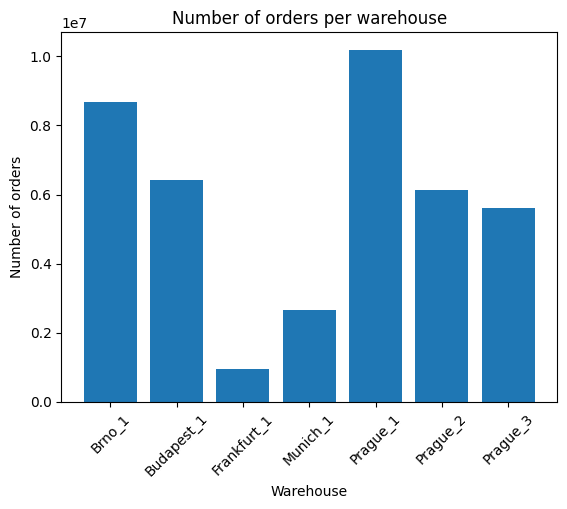

In [ ]:
orders_per_warehouse = train_df.groupby('warehouse')['orders'].sum()

plt.bar(orders_per_warehouse.index, orders_per_warehouse.values)
plt.title('Number of orders per warehouse')
plt.xlabel('Warehouse')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.show()

normalized number of orders per warehouse

In [ ]:
orders_per_warehouse = train_df.groupby('warehouse')['orders'].sum()
total_number_of_orders = train_df['orders'].sum()
normalized_orders_per_warehouse = orders_per_warehouse / total_number_of_orders
print(normalized_orders_per_warehouse.sort_values(ascending=False))

warehouse
Prague_1       0.250618
Brno_1         0.213598
Budapest_1     0.157801
Prague_2       0.150984
Prague_3       0.138177
Munich_1       0.065615
Frankfurt_1    0.023207
Name: orders, dtype: float64


# 04. Data processing

## 04.1. Drop

dropping columns not available in test_df

In [ ]:
train_df.drop(columns=['shutdown', 'mini_shutdown','blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2'], axis=1, inplace=True)

for df in [train_df, test_df]:
    df.drop(columns='id', axis=1, inplace=True)

In [ ]:
train_df.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays'],
      dtype='object')

## 04.2. Data type

changing date data type

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_calendar_df['date'] = pd.to_datetime(train_calendar_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
test_calendar_df['date'] = pd.to_datetime(test_calendar_df['date'])

orders over time by warehouse line chart

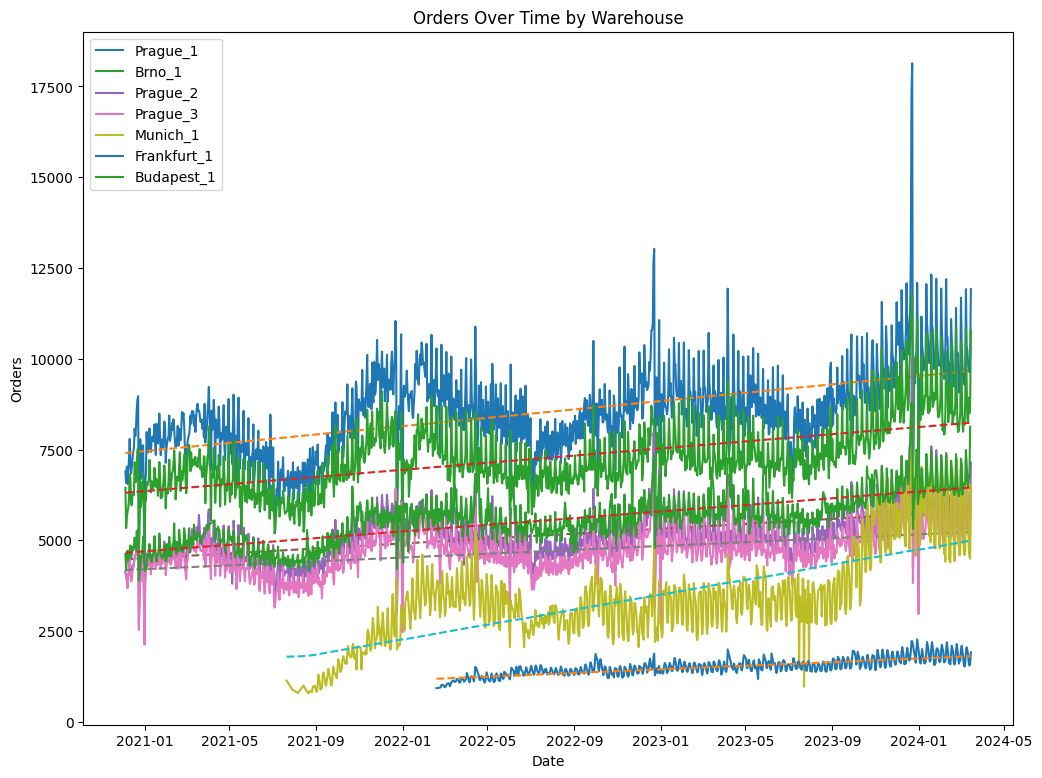

In [ ]:
plt.figure(figsize=(12, 9))

for warehouse in train_df['warehouse'].unique():
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_data['date'], warehouse_data['orders'], label=warehouse)

    trend_line = np.polyfit(range(len(warehouse_data)), warehouse_data['orders'], 1)
    plt.plot(warehouse_data['date'], np.polyval(trend_line, range(len(warehouse_data))), '--')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders Over Time by Warehouse')
plt.legend()
plt.show()

In [ ]:
min_date = train_df['date'].min()
max_date = train_df['date'].max()

print(min_date)
print(max_date)

2020-12-05 00:00:00
2024-03-15 00:00:00


date range by warehouse and df

In [ ]:
warehouse_list = list(train_df['warehouse'].unique())

for war in warehouse_list:
    print(f'Warehouse: {war} \n')
    for name in list(dataframes.keys())[:-1]:
        df = dataframes[name]
        print(name)
        warehouse_data = df[df['warehouse'] == war]

        print(f"min of date range: {warehouse_data['date'].min()}")
        print(f"max of date range: {warehouse_data['date'].max()}", "\n")

    print("------------------------------")

Warehouse: Prague_1 

train_df
min of date range: 2020-12-05 00:00:00
max of date range: 2024-03-15 00:00:00 

train_calendar_df
min of date range: 2019-01-01 00:00:00
max of date range: 2024-03-15 00:00:00 

test_df
min of date range: 2024-03-16 00:00:00
max of date range: 2024-05-15 00:00:00 

test_calendar_df
min of date range: 2024-03-16 00:00:00
max of date range: 2024-12-07 00:00:00 

------------------------------
Warehouse: Brno_1 

train_df
min of date range: 2020-12-05 00:00:00
max of date range: 2024-03-15 00:00:00 

train_calendar_df
min of date range: 2019-01-01 00:00:00
max of date range: 2024-03-15 00:00:00 

test_df
min of date range: 2024-03-16 00:00:00
max of date range: 2024-05-15 00:00:00 

test_calendar_df
min of date range: 2024-03-16 00:00:00
max of date range: 2024-12-07 00:00:00 

------------------------------
Warehouse: Prague_2 

train_df
min of date range: 2020-12-05 00:00:00
max of date range: 2024-03-15 00:00:00 

train_calendar_df
min of date range: 2019

## 04.3. Fill NaN

(tutaj uzupełnić dane średnią z poprzedniego i kolejnego dnia tygodnia lub 0 jeśli jest święto)

holiday name value counts

In [ ]:
train_df['holiday_name'].isna().sum()

7122

In [ ]:
train_df['holiday_name'].fillna(value="No holiday", inplace=True)
test_df['holiday_name'].fillna(value="No holiday", inplace=True)

/tmp/ipykernel_34/3339699178.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['holiday_name'].fillna(value="No holiday", inplace=True)
/tmp/ipykernel_34/3339699178.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

# 05. Data processing / modeling

## 05.1. Adding variables

## 05.2. Manual data mapping

mapping holiday_name by value counts groups

In [ ]:
holiday_counts = train_df['holiday_name'].value_counts()
holiday_counts

holiday_name
No holiday                                                     7122
International womens day                                         26
Christmas Eve                                                    23
2nd Christmas Day                                                16
New Years Day                                                    16
Good Friday                                                      12
Easter Monday                                                    12
Labour Day                                                       12
Den osvobozeni                                                   12
Cyrila a Metodej                                                 12
Jan Hus                                                          12
Den ceske statnosti                                              12
Den vzniku samostatneho ceskoslovenskeho statu                   12
Den boje za svobodu a demokracii                                 12
Memorial Day of the Republic       

predictor functions

In [ ]:
def add_holiday_features(df):
    df['is_holiday'] = (df['holiday_name'] != 'No holiday').astype(int)
    df['is_day_before_holiday'] = df.groupby('warehouse')['is_holiday'].shift(-1).fillna(0)
    df['is_day_after_holiday'] = df.groupby('warehouse')['is_holiday'].shift(1).fillna(0)
    return df


def map_holiday_name(df):
    holiday_counts = df['holiday_name'].value_counts().to_dict()

    def _map_single_holiday(holiday_name):
        count = holiday_counts.get(holiday_name, 0)
        if holiday_name == 'No holiday':
            return 0
        elif count >= 12:
            return 2
        else:
            return 1

    df['holiday_name_mapped'] = df['holiday_name'].apply(_map_single_holiday)
    df.drop(columns=['holiday_name'], inplace=True)

    return df


def transform(df):
    df['weekday'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['season'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))

    # cyclical encoding
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)
    df['sin_season'] = np.sin(2 * np.pi * df['season'] / 4)
    df['cos_season'] = np.cos(2 * np.pi * df['season'] / 4)

    return df


def add_lagged_monthly_means(df):
    grouped = df.groupby(['warehouse', 'year', 'month'])['orders'].mean().reset_index()

    def get_lagged_year_month(date, months_ago):
        lagged_date = date - pd.DateOffset(months=months_ago)
        return lagged_date.year, lagged_date.month

    for i in range(2, 13):
        df[f'year_{i}months_ago'], df[f'month_{i}months_ago'] = zip(*df['date'].apply(lambda x: get_lagged_year_month(x, i)))

        df = pd.merge(
            df,
            grouped[['warehouse', 'year', 'month', 'orders']],
            left_on=['warehouse', f'year_{i}months_ago', f'month_{i}months_ago'],
            right_on=['warehouse', 'year', 'month'],
            how='left',
            suffixes=('', f'_{i}months_ago')
        )

        df = df.rename(columns={f'orders_{i}months_ago': f'lag_{i}months_num_of_orders_mean'})

        columns_to_drop = [f'year_{i}months_ago', f'month_{i}months_ago', 'year_y', 'month_y']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    lag_columns = [col for col in df.columns if col.startswith('lag_')]
    df[lag_columns] = df[lag_columns].fillna(0)

    return df


def calculate_friday_orders_ratio(df):

    def get_lagged_year_month(date, months_ago):
        lagged_date = date - pd.DateOffset(months=months_ago)
        return lagged_date.year, lagged_date.month

    grouped = df.groupby(['warehouse', 'year', 'month', 'weekday'])['orders'].mean().reset_index()

    friday_orders = grouped[grouped['weekday'] == 4].copy()
    non_friday_orders = grouped[grouped['weekday'] != 4].copy()

    non_friday_mean = non_friday_orders.groupby(['warehouse', 'year', 'month'])['orders'].mean().reset_index()
    non_friday_mean = non_friday_mean.rename(columns={'orders': 'non_friday_mean'})

    friday_ratio = pd.merge(
        friday_orders,
        non_friday_mean,
        on=['warehouse', 'year', 'month']
    )

    friday_ratio['friday_to_others_ratio'] = friday_ratio['orders'] / friday_ratio['non_friday_mean']

    for i in range(2, 13):
        df[f'year_{i}months_ago'], df[f'month_{i}months_ago'] = zip(*df['date'].apply(lambda x: get_lagged_year_month(x, i)))

        df = pd.merge(
            df,
            friday_ratio[['warehouse', 'year', 'month', 'friday_to_others_ratio']],
            left_on=['warehouse', f'year_{i}months_ago', f'month_{i}months_ago'],
            right_on=['warehouse', 'year', 'month'],
            how='left',
            suffixes=('', f'_{i}months_ago')
        )

        df = df.rename(columns={'friday_to_others_ratio': f'friday_to_others_ratio_{i}months_ago'})
        columns_to_drop = [f'year_{i}months_ago', f'month_{i}months_ago', f'year_{i}months_ago', f'month_{i}months_ago']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        df[f'friday_to_others_ratio_{i}months_ago'] = df[f'friday_to_others_ratio_{i}months_ago'].fillna(1)

    return df

def calculate_tuesday_orders_ratio(df):

    def get_lagged_year_month(date, months_ago):
        lagged_date = date - pd.DateOffset(months=months_ago)
        return lagged_date.year, lagged_date.month

    grouped = df.groupby(['warehouse', 'year', 'month', 'weekday'])['orders'].mean().reset_index()

    tuesday_orders = grouped[grouped['weekday'] == 1].copy()
    non_tuesday_orders = grouped[grouped['weekday'] != 1].copy()

    non_tuesday_mean = non_tuesday_orders.groupby(['warehouse', 'year', 'month'])['orders'].mean().reset_index()
    non_tuesday_mean = non_tuesday_mean.rename(columns={'orders': 'non_tuesday_mean'})

    tuesday_ratio = pd.merge(
        tuesday_orders,
        non_tuesday_mean,
        on=['warehouse', 'year', 'month']
    )

    tuesday_ratio['tuesday_to_others_ratio'] = tuesday_ratio['orders'] / tuesday_ratio['non_tuesday_mean']

    for i in range(2, 13):
        df[f'year_{i}months_ago'], df[f'month_{i}months_ago'] = zip(*df['date'].apply(lambda x: get_lagged_year_month(x, i)))

        df = pd.merge(
            df,
            tuesday_ratio[['warehouse', 'year', 'month', 'tuesday_to_others_ratio']],
            left_on=['warehouse', f'year_{i}months_ago', f'month_{i}months_ago'],
            right_on=['warehouse', 'year', 'month'],
            how='left',
            suffixes=('', f'_{i}months_ago')
        )

        df = df.rename(columns={'tuesday_to_others_ratio': f'tuesday_to_others_ratio_{i}months_ago'})
        columns_to_drop = [f'year_{i}months_ago', f'month_{i}months_ago', f'year_{i}months_ago', f'month_{i}months_ago']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        df[f'tuesday_to_others_ratio_{i}months_ago'] = df[f'tuesday_to_others_ratio_{i}months_ago'].fillna(1)

    return df

def drop_specified_columns(df):
    columns_to_drop=['month', 'day', 'weekday', 'year', 'season']
    df.drop(columns=columns_to_drop, inplace=True)
    return df

In [ ]:
for war in train_df['warehouse'].unique():
    display(train_df.query('warehouse == @war').head())

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,Prague_1,2020-12-05,6895.0,No holiday,0,0,0,0
1,Prague_1,2020-12-06,6584.0,No holiday,0,0,0,0
2,Prague_1,2020-12-07,7030.0,No holiday,0,0,0,0
3,Prague_1,2020-12-08,6550.0,No holiday,0,0,0,0
4,Prague_1,2020-12-09,6910.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
1193,Brno_1,2020-12-05,6447.0,No holiday,0,0,0,0
1194,Brno_1,2020-12-06,5338.0,No holiday,0,0,0,0
1195,Brno_1,2020-12-07,5621.0,No holiday,0,0,0,0
1196,Brno_1,2020-12-08,5792.0,No holiday,0,0,0,0
1197,Brno_1,2020-12-09,5894.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
2386,Prague_2,2020-12-05,4154.0,No holiday,0,0,0,0
2387,Prague_2,2020-12-06,4016.0,No holiday,0,0,0,0
2388,Prague_2,2020-12-07,3917.0,No holiday,0,0,0,0
2389,Prague_2,2020-12-08,4038.0,No holiday,0,0,0,0
2390,Prague_2,2020-12-09,4017.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
3579,Prague_3,2020-12-05,4091.0,No holiday,0,0,0,0
3580,Prague_3,2020-12-06,3972.0,No holiday,0,0,0,0
3581,Prague_3,2020-12-07,3903.0,No holiday,0,0,0,0
3582,Prague_3,2020-12-08,3684.0,No holiday,0,0,0,0
3583,Prague_3,2020-12-09,4063.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
4772,Munich_1,2021-07-21,1139.0,No holiday,0,0,0,0
4773,Munich_1,2021-07-29,890.0,No holiday,0,0,0,0
4774,Munich_1,2021-08-06,797.0,No holiday,0,0,0,0
4775,Munich_1,2021-08-13,979.0,No holiday,0,0,0,0
4776,Munich_1,2021-08-14,1002.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
5557,Frankfurt_1,2022-02-18,929.0,No holiday,0,0,0,0
5558,Frankfurt_1,2022-02-19,931.0,No holiday,0,0,0,0
5559,Frankfurt_1,2022-02-23,945.0,No holiday,0,0,0,0
5560,Frankfurt_1,2022-02-24,955.0,No holiday,0,0,0,0
5561,Frankfurt_1,2022-02-25,1022.0,No holiday,0,0,0,0


,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
6186,Budapest_1,2020-12-05,4623.0,No holiday,0,0,0,0
6187,Budapest_1,2020-12-06,4197.0,No holiday,0,0,0,0
6188,Budapest_1,2020-12-07,4452.0,No holiday,0,0,0,0
6189,Budapest_1,2020-12-08,4714.0,No holiday,0,0,0,0
6190,Budapest_1,2020-12-09,4450.0,No holiday,0,0,0,0


In [ ]:
train_df_2 = train_df.copy()

In [ ]:
train_df_2

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,Prague_1,2020-12-05,6895.0,No holiday,0,0,0,0
1,Prague_1,2020-12-06,6584.0,No holiday,0,0,0,0
2,Prague_1,2020-12-07,7030.0,No holiday,0,0,0,0
3,Prague_1,2020-12-08,6550.0,No holiday,0,0,0,0
4,Prague_1,2020-12-09,6910.0,No holiday,0,0,0,0
...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,No holiday,0,0,0,0
7336,Budapest_1,2024-03-11,6492.0,No holiday,0,0,0,0
7337,Budapest_1,2024-03-12,6661.0,No holiday,0,0,0,0
7338,Budapest_1,2024-03-13,6843.0,No holiday,0,0,0,0


In [ ]:
transformed_train_df = train_df\
.pipe(add_holiday_features)\
.pipe(map_holiday_name)\
.pipe(transform)\
.pipe(calculate_friday_orders_ratio)\
.pipe(calculate_tuesday_orders_ratio)\
.pipe(add_lagged_monthly_means)\
.pipe(drop_specified_columns)

In [ ]:
transformed_train_df.columns

Index(['warehouse', 'date', 'orders', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'is_holiday',
       'is_day_before_holiday', 'is_day_after_holiday', 'holiday_name_mapped',
       'is_weekend', 'sin_day_of_week', 'cos_day_of_week', 'sin_month',
       'cos_month', 'sin_day', 'cos_day', 'sin_season', 'cos_season',
       'friday_to_others_ratio_2months_ago',
       'friday_to_others_ratio_3months_ago',
       'friday_to_others_ratio_4months_ago',
       'friday_to_others_ratio_5months_ago',
       'friday_to_others_ratio_6months_ago',
       'friday_to_others_ratio_7months_ago',
       'friday_to_others_ratio_8months_ago',
       'friday_to_others_ratio_9months_ago',
       'friday_to_others_ratio_10months_ago',
       'friday_to_others_ratio_11months_ago',
       'friday_to_others_ratio_12months_ago',
       'tuesday_to_others_ratio_2months_ago',
       'tuesday_to_others_ratio_3months_ago',
       'tuesday_to_others_ratio_4months_ago',
       'tues

# 06. Modeling

In [ ]:
grouped_df = transformed_train_df.groupby('warehouse')['date'].agg(['min', 'max'])
grouped_df['num_of_days'] = (grouped_df['max'] - grouped_df['min']).dt.days
grouped_df

,min,max,num_of_days
warehouse,,,
Brno_1,2020-12-05,2024-03-15,1196
Budapest_1,2020-12-05,2024-03-14,1195
Frankfurt_1,2022-02-18,2024-03-15,756
Munich_1,2021-07-21,2024-03-15,968
Prague_1,2020-12-05,2024-03-15,1196
Prague_2,2020-12-05,2024-03-15,1196
Prague_3,2020-12-05,2024-03-15,1196


In [ ]:
grouped_df = test_df.groupby('warehouse')['date'].agg(['min', 'max'])
grouped_df['num_of_days'] = (grouped_df['max'] - grouped_df['min']).dt.days
grouped_df

,min,max,num_of_days
warehouse,,,
Brno_1,2024-03-16,2024-05-15,60
Budapest_1,2024-03-16,2024-05-15,60
Frankfurt_1,2024-03-16,2024-05-15,60
Munich_1,2024-03-16,2024-05-15,60
Prague_1,2024-03-16,2024-05-15,60
Prague_2,2024-03-16,2024-05-15,60
Prague_3,2024-03-16,2024-05-15,60


In [ ]:
extra_regressors = set(transformed_train_df.columns) - set(['warehouse', 'date', 'orders'])
extra_regressors = list(extra_regressors)
extra_regressors.sort()

extra_regressors

['cos_day',
 'cos_day_of_week',
 'cos_month',
 'cos_season',
 'friday_to_others_ratio_10months_ago',
 'friday_to_others_ratio_11months_ago',
 'friday_to_others_ratio_12months_ago',
 'friday_to_others_ratio_2months_ago',
 'friday_to_others_ratio_3months_ago',
 'friday_to_others_ratio_4months_ago',
 'friday_to_others_ratio_5months_ago',
 'friday_to_others_ratio_6months_ago',
 'friday_to_others_ratio_7months_ago',
 'friday_to_others_ratio_8months_ago',
 'friday_to_others_ratio_9months_ago',
 'holiday',
 'holiday_name_mapped',
 'is_day_after_holiday',
 'is_day_before_holiday',
 'is_holiday',
 'is_weekend',
 'lag_10months_num_of_orders_mean',
 'lag_11months_num_of_orders_mean',
 'lag_12months_num_of_orders_mean',
 'lag_2months_num_of_orders_mean',
 'lag_3months_num_of_orders_mean',
 'lag_4months_num_of_orders_mean',
 'lag_5months_num_of_orders_mean',
 'lag_6months_num_of_orders_mean',
 'lag_7months_num_of_orders_mean',
 'lag_8months_num_of_orders_mean',
 'lag_9months_num_of_orders_mean',
 '

In [ ]:
len(extra_regressors)

50

In [ ]:
transformed_train_df = transformed_train_df[transformed_train_df['date'] >= pd.to_datetime('2022-01-01')]

In [ ]:
transformed_train_df

,warehouse,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays,is_holiday,is_day_before_holiday,is_day_after_holiday,...,lag_3months_num_of_orders_mean,lag_4months_num_of_orders_mean,lag_5months_num_of_orders_mean,lag_6months_num_of_orders_mean,lag_7months_num_of_orders_mean,lag_8months_num_of_orders_mean,lag_9months_num_of_orders_mean,lag_10months_num_of_orders_mean,lag_11months_num_of_orders_mean,lag_12months_num_of_orders_mean
390,Prague_1,2022-01-01,4309.0,1,1,0,0,1,0.0,0.0,...,8204.483871,7365.100000,6759.354839,6534.483871,7206.100000,7612.741935,8086.600000,8201.870968,7932.214286,7583.516129
391,Prague_1,2022-01-02,8994.0,0,0,0,0,0,0.0,1.0,...,8204.483871,7365.100000,6759.354839,6534.483871,7206.100000,7612.741935,8086.600000,8201.870968,7932.214286,7583.516129
392,Prague_1,2022-01-03,9259.0,0,0,0,0,0,0.0,0.0,...,8204.483871,7365.100000,6759.354839,6534.483871,7206.100000,7612.741935,8086.600000,8201.870968,7932.214286,7583.516129
393,Prague_1,2022-01-04,8954.0,0,0,0,0,0,0.0,0.0,...,8204.483871,7365.100000,6759.354839,6534.483871,7206.100000,7612.741935,8086.600000,8201.870968,7932.214286,7583.516129
394,Prague_1,2022-01-05,9038.0,0,0,0,0,0,0.0,0.0,...,8204.483871,7365.100000,6759.354839,6534.483871,7206.100000,7612.741935,8086.600000,8201.870968,7932.214286,7583.516129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7335,Budapest_1,2024-03-10,6733.0,0,0,0,0,0,0.0,0.0,...,6926.931034,6365.517241,6254.633333,5955.000000,5709.533333,5546.096774,5674.433333,5884.535714,5961.962963,5907.200000
7336,Budapest_1,2024-03-11,6492.0,0,0,0,0,0,0.0,0.0,...,6926.931034,6365.517241,6254.633333,5955.000000,5709.533333,5546.096774,5674.433333,5884.535714,5961.962963,5907.200000
7337,Budapest_1,2024-03-12,6661.0,0,0,0,0,0,0.0,0.0,...,6926.931034,6365.517241,6254.633333,5955.000000,5709.533333,5546.096774,5674.433333,5884.535714,5961.962963,5907.200000
7338,Budapest_1,2024-03-13,6843.0,0,0,0,0,0,0.0,0.0,...,6926.931034,6365.517241,6254.633333,5955.000000,5709.533333,5546.096774,5674.433333,5884.535714,5961.962963,5907.200000


## 06.1. Ensemble model

Warehouse: Prague_1
MAPE: 5.79%


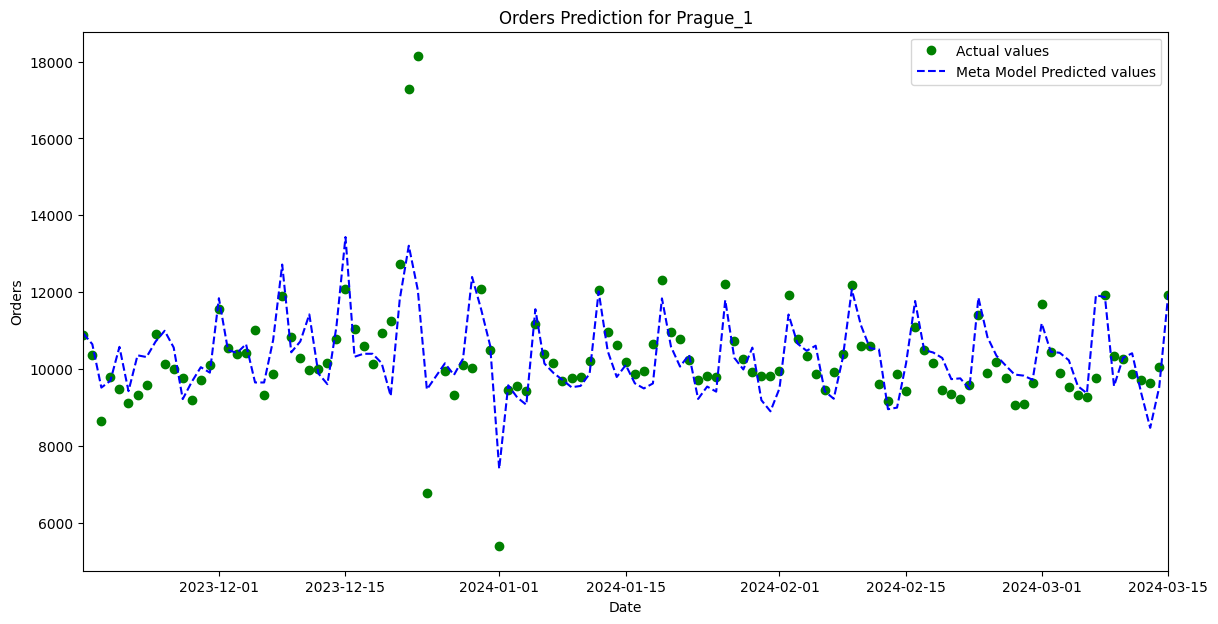

Warehouse: Brno_1
MAPE: 5.21%


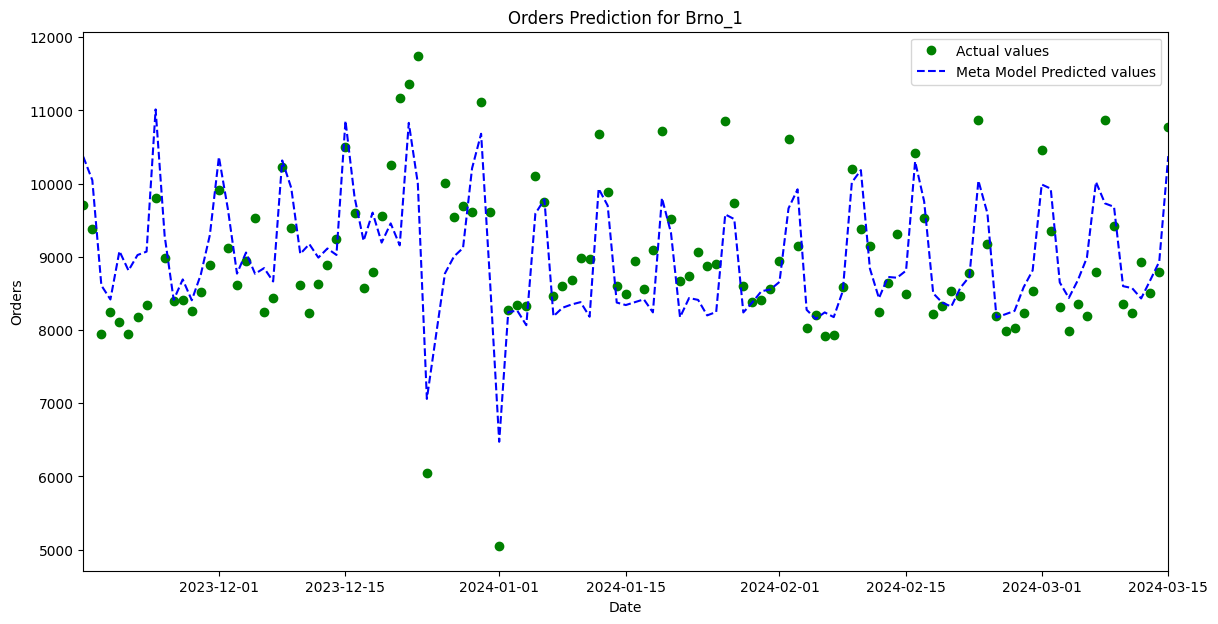

Warehouse: Prague_2
MAPE: 5.11%


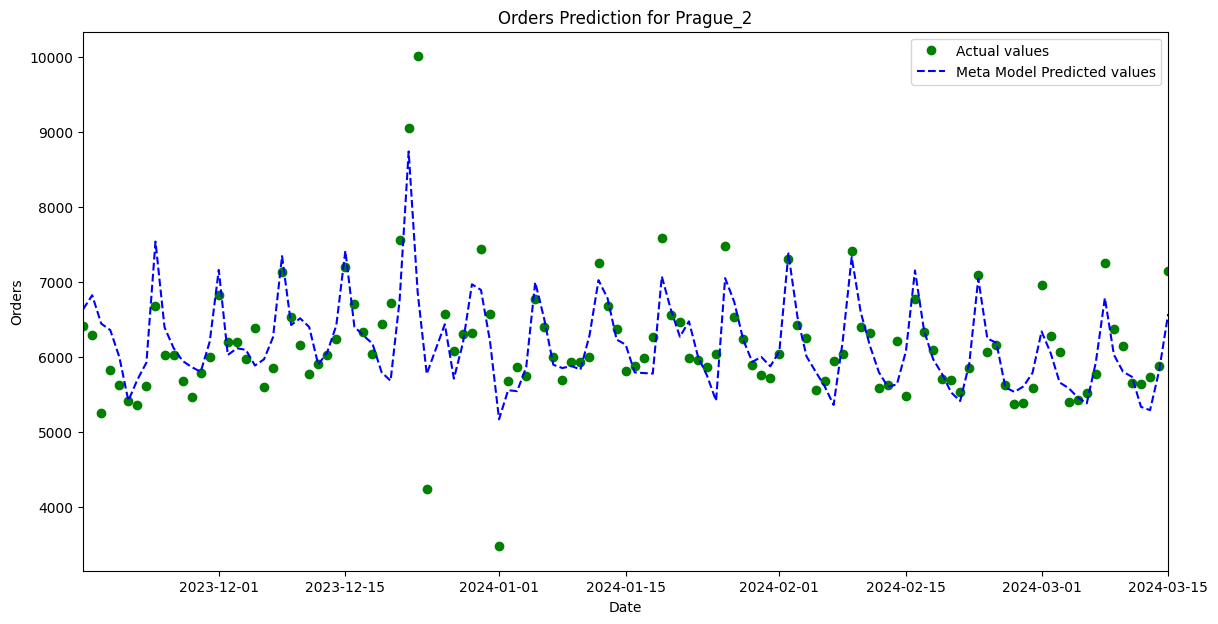

Warehouse: Prague_3
MAPE: 4.96%


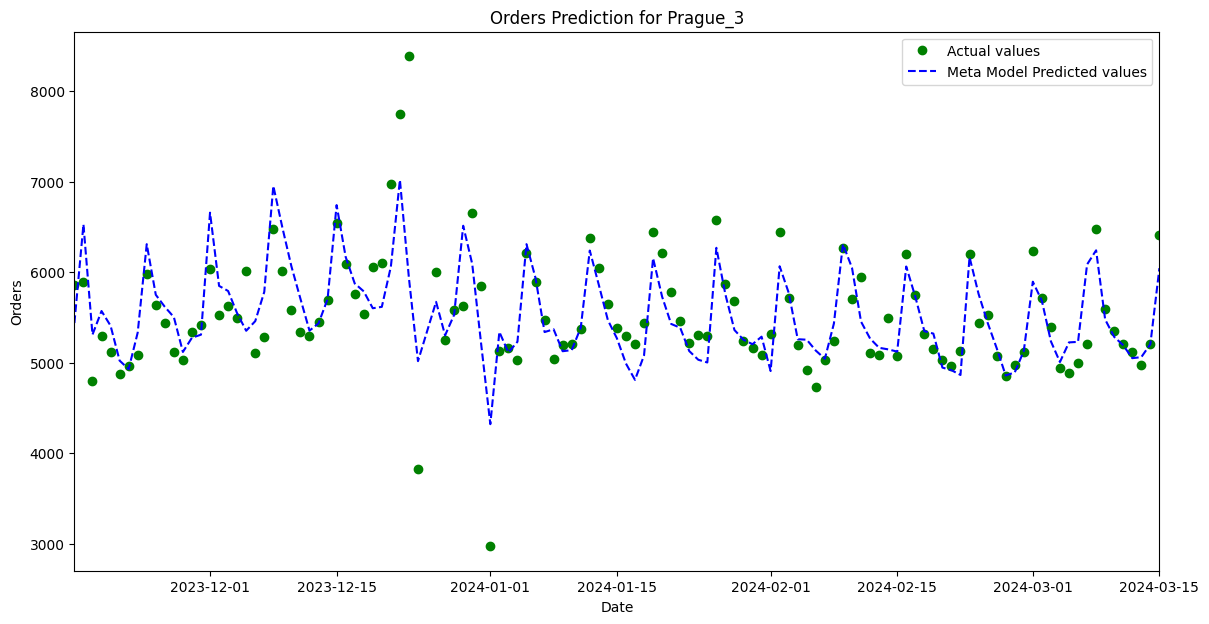

Warehouse: Munich_1
MAPE: 8.77%


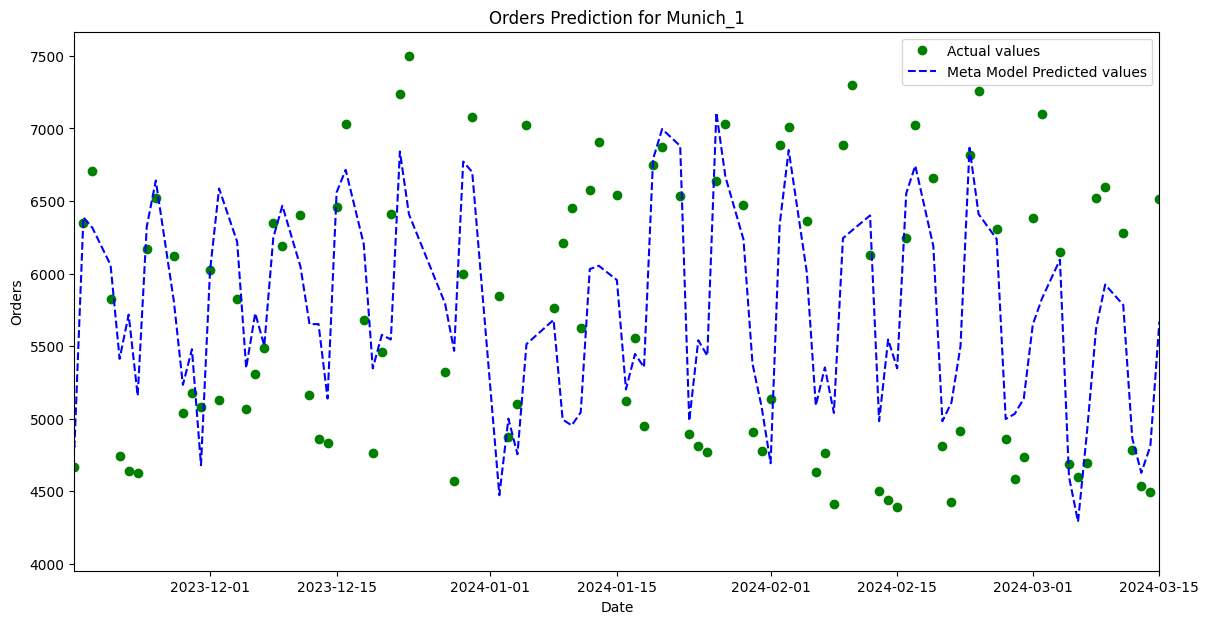

Warehouse: Frankfurt_1
MAPE: 4.44%


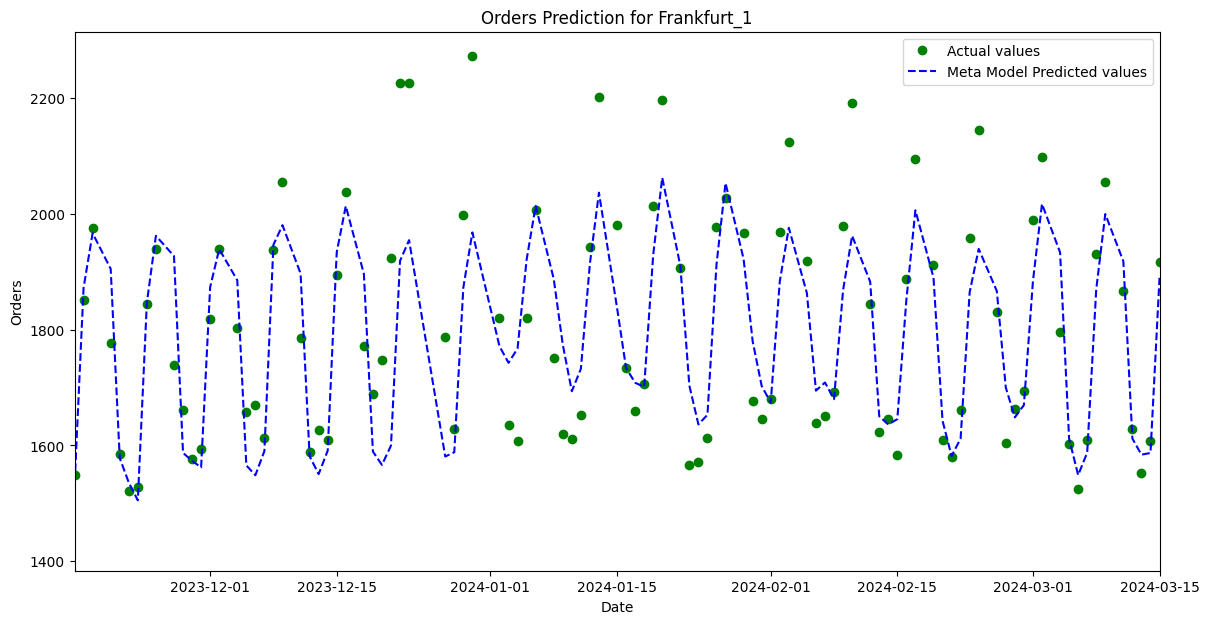

Warehouse: Budapest_1
MAPE: 4.62%


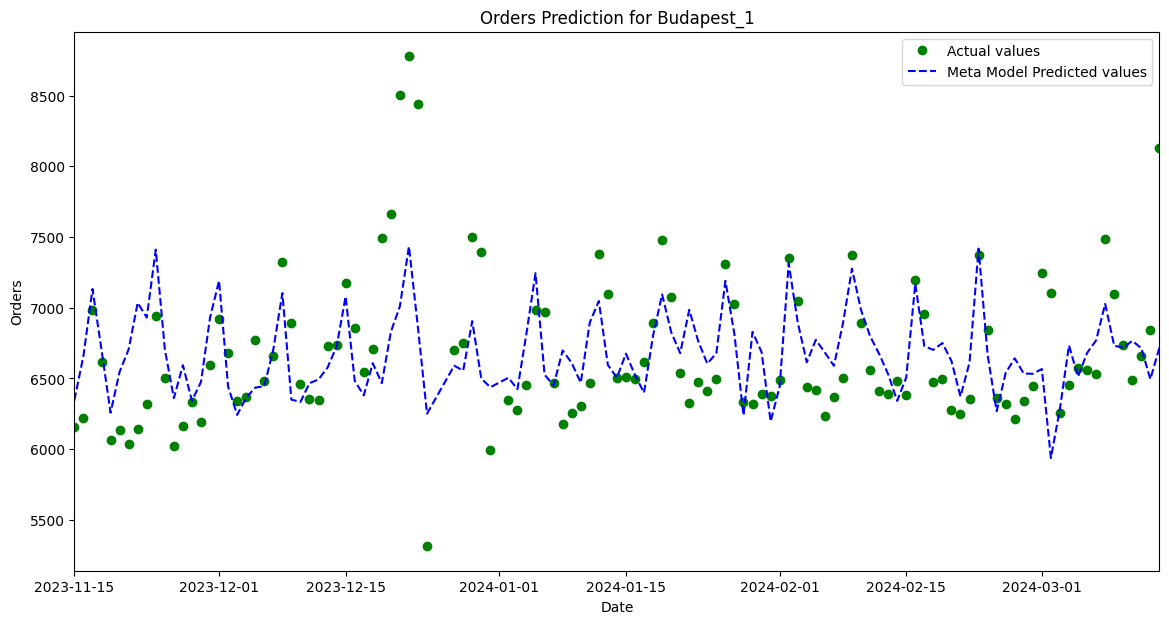

Aggregated MAPE: 5.56%


In [ ]:
warnings.filterwarnings('ignore')
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

results_df = pd.DataFrame()
all_actuals = pd.DataFrame()
all_predictions = pd.DataFrame()

cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

for warehouse in transformed_train_df['warehouse'].unique():
    warehouse_df = transformed_train_df[transformed_train_df['warehouse'] == warehouse].copy()
    train_df = warehouse_df.iloc[:-120]
    test_df = warehouse_df.iloc[-120:]

    prophet_train = train_df[['date', 'orders']].rename(columns={'date': 'ds', 'orders': 'y'})

    prophet_model = Prophet()
    prophet_model.fit(prophet_train)

    future = prophet_model.make_future_dataframe(periods=len(test_df))
    forecast = prophet_model.predict(future)

    test_df['prophet_pred'] = forecast['yhat'].iloc[-len(test_df):].values

    regressors = list(set(train_df.columns) - {'warehouse', 'date', 'orders'})
    X_train = train_df[regressors]
    y_train = train_df['orders']
    X_test = test_df[regressors]

    rf_model = RandomForestRegressor()
    xgb_model = XGBRegressor()
    lgb_model = LGBMRegressor(verbose=-1)
    cat_model = CatBoostRegressor(verbose=0)
    lr_model = LinearRegression()
    ad_model = AdaBoostRegressor()
    dt_model = DecisionTreeRegressor()
    gb_model = GradientBoostingRegressor()

    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)
    ad_model.fit(X_train, y_train)
    dt_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    test_df['rf_pred'] = rf_model.predict(X_test)
    test_df['xgb_pred'] = xgb_model.predict(X_test)
    test_df['lgb_pred'] = lgb_model.predict(X_test)
    test_df['cat_pred'] = cat_model.predict(X_test)
    test_df['lr_pred'] = lr_model.predict(X_test)
    test_df['ad_pred'] = ad_model.predict(X_test)
    test_df['dt_pred'] = dt_model.predict(X_test)
    test_df['gb_pred'] = gb_model.predict(X_test)

    meta_features = test_df[['prophet_pred', 'rf_pred', 'xgb_pred', 'lgb_pred', 'cat_pred', 'lr_pred', 'ad_pred', 'dt_pred', 'gb_pred']]
    meta_model = LinearRegression()
    meta_model.fit(meta_features, test_df['orders'])

    test_df['meta_pred'] = meta_model.predict(meta_features)

    mape = mean_absolute_percentage_error(test_df['orders'], test_df['meta_pred'])
    print(f"Warehouse: {warehouse}")
    print(f"MAPE: {mape:.2%}")

    all_actuals = pd.concat([all_actuals, test_df[['warehouse', 'date', 'orders']]])
    all_predictions = pd.concat([all_predictions, test_df[['warehouse', 'date', 'meta_pred']]])

    #plot
    plt.figure(figsize=(14, 7))
    plt.plot(test_df['date'], test_df['orders'], 'go', label='Actual values')
    plt.plot(test_df['date'], test_df['meta_pred'], 'b--', label='Meta Model Predicted values')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.title(f'Orders Prediction for {warehouse}')
    plt.legend()

    last_date = test_df['date'].max()
    start_date = last_date - pd.Timedelta(days=120)
    plt.xlim([start_date, last_date])

    plt.show()

aggregated_mape = mean_absolute_percentage_error(all_actuals['orders'], all_predictions['meta_pred'])
print(f"Aggregated MAPE: {aggregated_mape:.2%}")